### Model Template

We define a template model to keep the training process consistent across the models we are comparing. Each model makes use of the same training, validation and testing set we have created.

Based on our Research Questions, we have the following models to compare:

1. Single Task Learning v Multi Task Learning.
As we have two measurements we want to estimate, temperature and relative humidity, we train two models that each use one feature, and a third model that uses both features.

2. Colour Images v Greyscale Images
We assume these models to be Multi Task. We train one model on the default images that uses three colour channels, RGB. The second model also uses three colour channels, but each channel is equal, so the image is effectively in greyscale.

3. Image Size
We assume these models to be Multi Task. Until this point, all models have been trained on images with 256 x 256 pixels. This is the largest size we use. We then compare with progressively smaller image sizes, 128 x 128, 64 x 64.

Ultimately this gives us 6 models, as the Multitask model with Colour images is reused.

(SingleTaskTemperature, SingleTaskHumidity, MultiTask = MultiTaskColour = MultiTask256, MultiTaskGrey, MultiTask128, MultiTask64)

Based on the model you are training, make sure to keep the image size consistent, as well as the number of outputs. When dealing with multiple outputs, we need to plot each output separately and calculate a rmse for each.

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image
from pathlib import Path
import torch.nn
import torchvision
import tensorflow as tf
import torchvision.transforms as transforms
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [73]:
# Specify csv data file
traindf = pd.read_csv("train.csv")
valdf = pd.read_csv("val.csv")
testdf = pd.read_csv("test.csv")

In [74]:
traindf.head()

,stationId,imageDate,imgPath,meteoDate,dew,humidity,precipitation,roadCondition,temperature C bellow 5cm,temperature C 0cm,temperature C 20cm,temperature C 2m,warnings,wind direction,speed[m/s],imageDate_t,imageDate_ts,cluster,time
0,757-1,13/11/2018 12:30,/save/757-1/3/1542112203_757-1.jpg,13/11/2018 12:20,6.5,52.2,none,dry,0,20.1,14.0,16.3,none,241,0.5,13/11/2018 12:30,304203,3,12:30:03
1,1686-0,3/12/2018 11:17,/save/1686-0/59/1543835859_1686-0.jpg,3/12/2018 11:20,3.8,86.6,unknown,wet,0,6.3,0.0,5.9,none/unknown,359,1.3,3/12/2018 11:17,2027859,3,11:17:39
2,179-0,22/12/2018 12:50,/save/179-0/36/1545483036_179-0.jpg,22/12/2018 12:50,4.3,88.6,none,wet,0,10.7,5.6,6.1,none,308,0.4,22/12/2018 12:50,3675036,1,12:50:36
3,146-0,17/11/2018 13:10,/save/146-0/0/1542460200_146-0.jpg,17/11/2018 13:00,-3.9,65.2,none,dry,0,9.1,5.1,1.9,none/unknown,92,1.8,17/11/2018 13:10,652200,3,13:10:00
4,53-0,18/11/2018 13:12,/save/53-0/78/1542546778_53-0.jpg,18/11/2018 14:09,-3.7,67.1,unknown,dry,0,4.9,0.0,1.6,none,317,0.0,18/11/2018 13:12,738778,3,13:12:58


First, we need to extract the features we require for our task and desired transformations.

In [75]:
def featureTransformation(df, output, size, colour):
    numExamples = df.shape[0]
    #singletasks
    if output == "humidity":
        outputFeature = np.asarray(df['humidity'])
    elif output == "temperature":
        outputFeature = np.asarray(df['temperature C 2m'])
    else:
        #multitask
        f1 = np.asarray(df['humidity'])
        f2 = np.asarray(df['temperature C 2m'])
        outputFeature = np.asarray([(f1[i], f2[i]) for i in range(numExamples)])

    imgCol = df.columns.get_loc("imgPath")
    imgFeature = []
    for i in range(numExamples):
        imgPath = df.iloc[i][imgCol]

        #process
        imgPath = "." + imgPath
        img = Image.open(Path(imgPath))
        img = img.convert('RGB')
        
        #size
        if size == 256:
            transformedImg = transforms.Resize((256,256))(img)
        elif size == 128:
            transformedImg = transforms.Resize((128,128))(img)
        else:
            transformedImg = transforms.Resize((64,64))(img)  
        
        #greyscale or not
        if colour == "grey":
            transformedImg = transforms.Grayscale(3)(transformedImg)
        
        #normalisation
        transformedImg = np.asarray(transformedImg)
        transformedImg = transformedImg / 255

        #plot some example images
        if i % 2000 == 0:
            plt.imshow(transformedImg)
            plt.show()

        imgFeature.append(transformedImg)

    imgFeature = np.asarray(imgFeature)
    
    return imgFeature, outputFeature

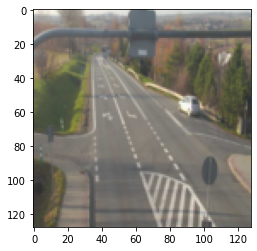

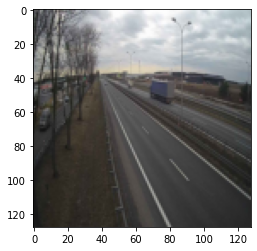

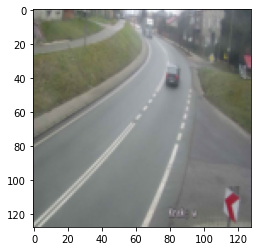

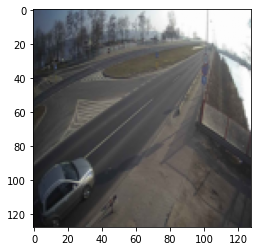

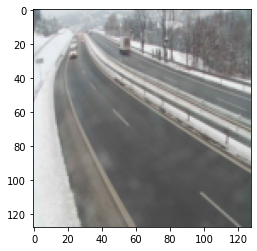

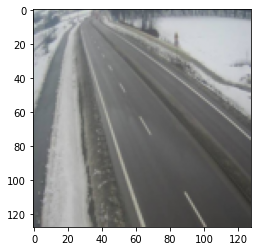

In [76]:
#define output, colour, and size
#output = "humidity"
#output = "temperature"
output = "both"

colour = "colour"
#colour = "grey"

#size = 256
size = 128
#size = 64

X_train, Y_train = featureTransformation(traindf, output, size, colour)
X_val, Y_val = featureTransformation(valdf, output, size, colour)
X_test, Y_test = featureTransformation(testdf, output, size, colour)

Now to train the model. We also save a copy.

In [77]:
#we make use of the same model in each case
image_input = Input(batch_size=8, shape=(128, 128, 3))
#model layers
conv1 = Conv2D(32, (3, 3), 1, padding='same', activation='relu')(image_input)
conv2 = Conv2D(64, (3, 3), 1, activation='relu')(conv1)
maxpool1 = MaxPooling2D((2, 2))(conv2)
dropout = Dropout(0.25)(maxpool1)
flatten = Flatten()(dropout)
image_dense = Dense(128, activation='relu')(flatten)
#two output nodes as we predict multitask
output = Dense(2, activation='linear')(image_dense)
model = Model(inputs=image_input, outputs=output)

#train
model.compile(optimizer='adam', loss='mean_squared_error') 
print(model.summary())
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=10, batch_size=8, verbose=1)

#saving the model - rename as desired
filename = "multitask128_CNN.sav"
pickle.dump(model, open(filename, 'wb'))

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(8, 128, 128, 3)]        0         
                                                                 
 conv2d_12 (Conv2D)          (8, 128, 128, 32)         896       
                                                                 
 conv2d_13 (Conv2D)          (8, 126, 126, 64)         18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (8, 63, 63, 64)           0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (8, 63, 63, 64)           0         
                                                                 
 flatten_6 (Flatten)         (8, 254016)               0         
                                                           

Testing and Analysis

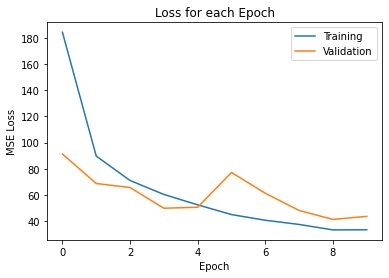

In [78]:
#plotting the loss 
epochs = np.arange(10)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.legend(["Training", "Validation"])
plt.title("Loss for each Epoch")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

In [79]:
#make predictions
#first humidity
Y_pred = np.transpose(np.asarray(model.predict(X_test)))
Y_predHum = Y_pred[0]
Y_predTemp = Y_pred[1]
Y_testHum = Y_test[:, 0]
Y_testTemp = Y_test[:, 1]

humidityRmse = np.sqrt(((Y_testHum - Y_predHum)**2).mean(axis=0))
print("Model Humidity RMSE: {}\n".format(np.round(humidityRmse, 4)))

#print a few predictions
print("True \t Prediction")
for i in range(10):
    print("{} \t {}".format(Y_testHum[i], np.round(Y_predHum[i], 4)))
    
print("")
    
#then temperature
temperatureRmse = np.sqrt(((Y_testTemp - Y_predTemp)**2).mean(axis=0))
print("Model Temperature RMSE: {}\n".format(np.round(temperatureRmse, 4)))

#print a few predictions
print("True \t Prediction")
for i in range(10):
    print("{} \t {}".format(Y_testTemp[i], np.round(Y_predTemp[i], 4)))

24/24 [==============================] - 3s 108ms/step
Model Humidity RMSE: 8.8695

True 	 Prediction
94.9 	 90.44580078125
92.1 	 93.7948989868164
87.7 	 87.345703125
47.7 	 47.71780014038086
39.3 	 60.062400817871094
90.0 	 95.19029998779297
95.8 	 91.79440307617188
48.0 	 58.85279846191406
99.0 	 96.42720031738281
93.5 	 91.46420288085938

Model Temperature RMSE: 2.9499

True 	 Prediction
3.3 	 2.6703999042510986
6.2 	 5.665900230407715
0.0 	 6.19379997253418
-1.9 	 -2.3884999752044678
7.7 	 6.3282999992370605
-1.5 	 1.0886000394821167
-0.1 	 2.314500093460083
13.3 	 7.5553998947143555
1.2 	 2.9293999671936035
2.5 	 9.946800231933594


In [80]:
#save predictions
predictionData = {"imgPath": [], "True Humidity": [], "Predicted Humidity": [], "True Temperature": [], "Predicted Temperature": []}
numPreds = len(Y_test)
for i in range(numPreds):
    predictionData["imgPath"].append(testdf.iloc[i][2])
    predictionData["True Humidity"].append(Y_testHum[i])
    predictionData["Predicted Humidity"].append(Y_predHum[i])
    predictionData["True Temperature"].append(Y_testTemp[i])
    predictionData["Predicted Temperature"].append(Y_predTemp[i])
predictionData = pd.DataFrame(predictionData)
predictionData.to_csv("multitask128_predictions.csv", index=False)

Humidity Predictions
True 94.9 	 Predicted 90.44584655761719


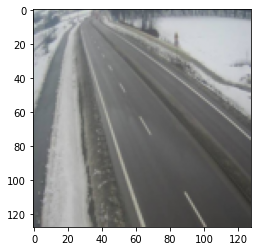

True 92.1 	 Predicted 93.79491424560547


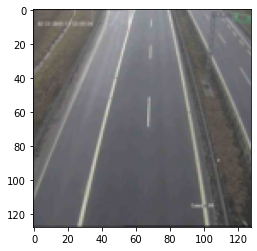

True 87.7 	 Predicted 87.3457260131836


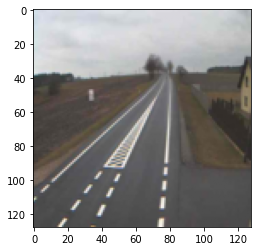

True 39.3 	 Predicted 60.06237030029297


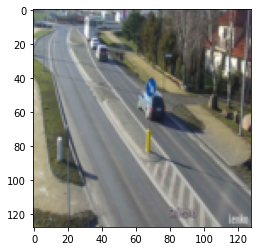

True 48.0 	 Predicted 58.852813720703125


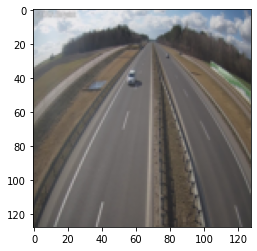

True 43.7 	 Predicted 58.09996032714844


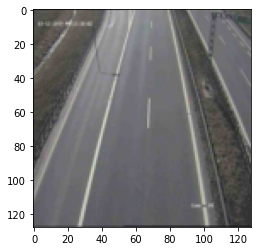

In [81]:
#plot a few images that were well predicted or poorly predicted
print("Humidity Predictions")
count = 0
for i in range(len(Y_predHum)):
    if count == 3:
        break
    if abs(Y_predHum[i] - Y_testHum[i]) < 5:
        count += 1
        print("True {} \t Predicted {}".format(Y_testHum[i], Y_predHum[i]))
        plt.imshow(X_test[i])
        plt.show()
count = 0
for i in range(len(Y_predHum)):
    if count == 3:
        break
    if abs(Y_predHum[i] - Y_testHum[i]) > 10:
        count += 1
        print("True {} \t Predicted {}".format(Y_testHum[i], Y_predHum[i]))
        plt.imshow(X_test[i])
        plt.show()

Temperature Predictions
True -1.9 	 Predicted -2.388498544692993


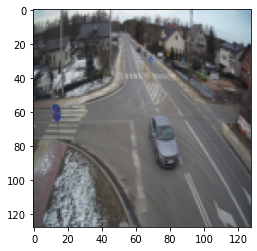

True 6.3 	 Predicted 5.978405475616455


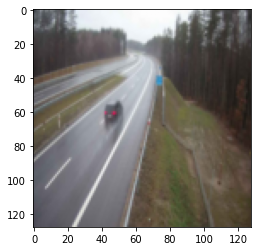

True 2.8 	 Predicted 3.284891366958618


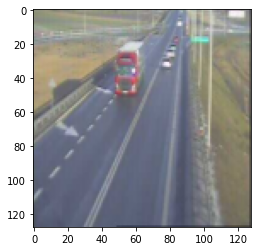

True 0.0 	 Predicted 6.1938371658325195


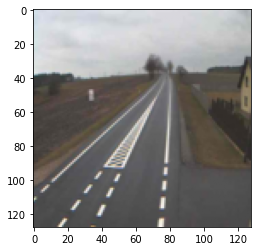

True 13.3 	 Predicted 7.555384159088135


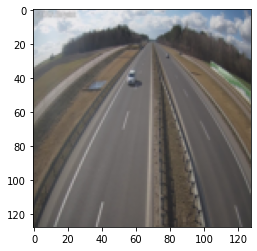

True 2.5 	 Predicted 9.94676685333252


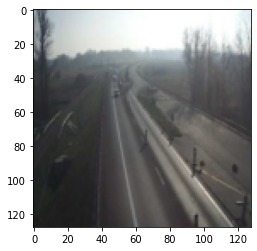

In [82]:
#plot a few images that were well predicted or poorly predicted
print("Temperature Predictions")
count = 0
for i in range(len(Y_predTemp)):
    if count == 3:
        break
    if abs(Y_predTemp[i] - Y_testTemp[i]) < 0.5:
        count += 1
        print("True {} \t Predicted {}".format(Y_testTemp[i], Y_predTemp[i]))
        plt.imshow(X_test[i])
        plt.show()
count = 0
for i in range(len(Y_predTemp)):
    if count == 3:
        break
    if abs(Y_predTemp[i] - Y_testTemp[i]) > 5:
        count += 1
        print("True {} \t Predicted {}".format(Y_testTemp[i], Y_predTemp[i]))
        plt.imshow(X_test[i])
        plt.show()

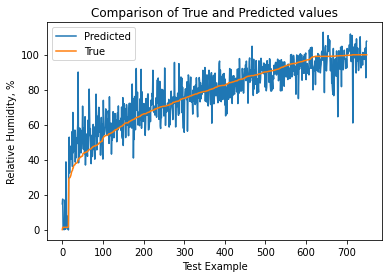

In [83]:
#also we can plot a prediction line
#sort from lowest true value to largest
numPreds = len(Y_test)
estimates = [(Y_testHum[i], Y_predHum[i]) for i in range(numPreds)]
estimates.sort(key=lambda x:x[0])

x = np.arange(numPreds)
y1 = [estimates[i][0] for i in range(numPreds)]
y2 = [estimates[i][1] for i in range(numPreds)]

plt.plot(x, y2)
plt.plot(x, y1)
plt.title("Comparison of True and Predicted values")
plt.xlabel("Test Example")
plt.ylabel("Relative Humidity, %")
plt.legend(["Predicted", "True"])
plt.show()

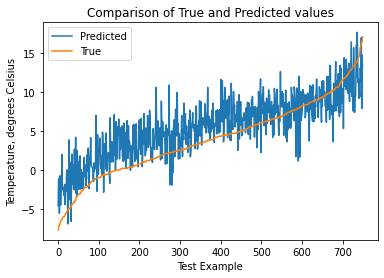

In [84]:
#also we can plot a prediction line
#sort from lowest true value to largest
numPreds = len(Y_test)
estimates = [(Y_testTemp[i], Y_predTemp[i]) for i in range(numPreds)]
estimates.sort(key=lambda x:x[0])

x = np.arange(numPreds)
y1 = [estimates[i][0] for i in range(numPreds)]
y2 = [estimates[i][1] for i in range(numPreds)]

plt.plot(x, y2)
plt.plot(x, y1)
plt.title("Comparison of True and Predicted values")
plt.xlabel("Test Example")
plt.ylabel("Temperature, degrees Celsius")
plt.legend(["Predicted", "True"])
plt.show()